In [3]:
import sys

# # Add the paths that facenet is in
# sys.path.insert(0, "../custom_facenet/src")
# sys.path.insert(0, "../custom_facenet/src/align")

In [40]:
import os
import random
import sklearn
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf # NOTE: this has to use Tensorflow version 1.x
import numpy as np
import cv2
import scipy as sp
import glob
import copy
import dlib
import math
import time
from skimage import io
from pathlib import Path
%matplotlib inline

=====================================================================
Large-scale Fashion Recognition and Retrieval (DeepFashion) Dataset
=====================================================================

=============================================
Category and Attribute Prediction Benchmark
=============================================

--------------------------------------------------------
By Multimedia Lab, The Chinese University of Hong Kong
--------------------------------------------------------

For more information about the dataset, visit the project website:

  http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

If you use the dataset in a publication, please cite the papers below:

  @inproceedings{liu2016deepfashion,
 	author = {Ziwei Liu, Ping Luo, Shi Qiu, Xiaogang Wang, and Xiaoou Tang},
 	title = {DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations},
 	booktitle = {Proceedings of IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
 	month = June,
 	year = {2016} 
  }

Please note that we do not own the copyrights to these images. Their use is RESTRICTED to non-commercial research and educational purposes.



========================
Change Log
========================

Version 1.0, released on 08/08/2016
Version 1.1, released on 22/12/2016, add landmarks annotations



========================
File Information
========================

- Images (Img/img.zip)
    289,222 diverse clothes images. See IMAGE section below for more info.

- Bounding Box Annotations (Anno/list_bbox.txt)
    bounding box labels. See BBOX LABELS section below for more info.

- Fashion Landmark Annotations (Anno/list_landmarks.txt)
	fashion landmark labels. See LANDMARK LABELS section below for more info.

- Category Annotations (Anno/list_category_cloth.txt & Anno/list_category_img.txt)
	clothing category labels. See CATEGORY LABELS section below for more info.

- Attribute Annotations (Anno/list_attr_cloth.txt & Anno/list_attr_img.txt)
	clothing attribute labels. See ATTRIBUTE LABELS section below for more info.

- Evaluation Partitions (Eval/list_eval_partition.txt)
	image names for training, validation and testing set respectively. See EVALUATION PARTITIONS section below for more info.



=========================
IMAGE
=========================

------------ img.zip ------------

format: JPG

---------------------------------------------------

Notes:
1. The long side of images are resized to 300;
2. The aspect ratios of original images are kept unchanged.

---------------------------------------------------



=========================
BBOX LABELS
=========================

------------ list_bbox.txt ------------

First Row: number of images
Second Row: entry names

Rest of the Rows: <image name> <bbox location>

---------------------------------------------------

Notes:
1. The order of bbox labels accords with the order of entry names;
2. In bbox location, "x_1" and "y_1" represent the upper left point coordinate of bounding box, "x_2" and "y_2" represent the lower right point coordinate of bounding box. Bounding box locations are listed in the order of [x_1, y_1, x_2, y_2].

---------------------------------------------------



=========================
LANDMARK LABELS
=========================

------------ list_landmarks.txt ------------

First Row: number of images
Second Row: entry names

Rest of the Rows: <image name> <clothes type> <variation type> [<landmark visibility 1> <landmark location x_1> <landmark location y_1>, ... <landmark visibility 8> <landmark location x_8> <landmark location y_8>]

---------------------------------------------------

Notes:
1. The order of landmark labels accords with the order of entry names;
2. In clothes type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes. Upper-body clothes possess six fahsion landmarks, lower-body clothes possess four fashion landmarks, full-body clothes possess eight fashion landmarks;
3. In variation type, "1" represents normal pose, "2" represents medium pose, "3" represents large pose, "4" represents medium zoom-in, "5" represents large zoom-in;
4. In landmark visibility state, "0" represents visible, "1" represents invisible/occluded, "2" represents truncated/cut-off;
5. For upper-body clothes, landmark annotations are listed in the order of ["left collar", "right collar", "left sleeve", "right sleeve", "left hem", "right hem"]; For lower-body clothes, landmark annotations are listed in the order of ["left waistline", "right waistline", "left hem", "right hem"]; For upper-body clothes, landmark annotations are listed in the order of ["left collar", "right collar", "left sleeve", "right sleeve", "left waistline", "right waistline", "left hem", "right hem"].

---------------------------------------------------



=========================
CATEGORY LABELS
=========================

--------------- list_category_cloth.txt --------------

First Row: number of categories
Second Row: entry names

Rest of the Rows: <category name> <category type>

--------------- list_category_img.txt --------------

First Row: number of images
Second Row: entry names

Rest of the Rows: <image name> <category label>

---------------------------------------------------

Notes:
1. In category type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes;
2. The order of category labels accords with the order of category names;
3. In category labels, the number represents the category id in category names;
4. For the clothing categories, "Cape", "Nightdress", "Shirtdress" and "Sundress" have been merged into "Dress";
5. Category prediction is treated as a 1-of-K classification problem.

---------------------------------------------------



=========================
ATTRIBUTE LABELS
=========================

--------------- list_attr_cloth.txt --------------

First Row: number of attributes
Second Row: entry names

Rest of the Rows: <attribute name> <attribute type>

--------------- list_attr_img.txt --------------

First Row: number of images
Second Row: entry names

Rest of the Rows: <image name> <attribute labels>

---------------------------------------------------

Notes:
1. In attribute type, "1" represents texture-related attributes, "2" represents fabric-related attributes, "3" represents shape-related attributes, "4" represents part-related attributes, "5" represents style-related attributes;
2. The order of attribute labels accords with the order of attribute names;
3. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
4. Attribute prediction is treated as a multi-label tagging problem.

---------------------------------------------------



=========================
EVALUATION PARTITIONS
=========================

------------- list_eval_partition.txt -------------

First Row: number of images
Second Row: entry names

Rest of the Rows: <image name> <evaluation status>

---------------------------------------------------

Notes:
1. In evaluation status, "train" represents training image, "val" represents validation image, "test" represents testing image;
2. Please refer to the paper "DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations" for more details.

---------------------------------------------------



=========================
Contact
=========================

Please contact Ziwei Liu (lz013@ie.cuhk.edu.hk) for questions about the dataset.

In [51]:
dataset_path = "./deepfashion/"
image_paths = glob.glob("deepfashion/img/**/*.jpg")

In [ ]:
"""
abstractprint
beaded
boxy
cami
chambray
chiffon
classic
crochet
cropped
dolman
embroidered
floral
hem
knit
lace
longsleeve
love
mesh
peasant
peplum
pink
printed
sheer
shirt
sleeve
sleeveless
striped
summer
woven

"""

In [49]:
def load_images(image_paths, offset=100):
    images = []
    for image_path in image_paths[:offset]:
        image = np.asarray(Image.open(image_path))
        images.append(image)
    return(np.array(images))

offset = 100
images = load_images(image_paths, offset=offset)

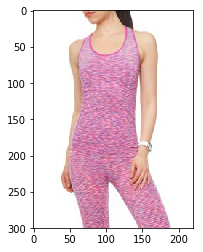

In [50]:
plt.imshow(images[random.randint(0,offset-1)])

In [63]:
# load annots and eval
# Total 50: "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes
cat_cloth_file = os.path.join(dataset_path, 'Anno/list_category_cloth.txt')
cat_img_file = os.path.join(dataset_path, 'Anno/list_category_img.txt')
attr_cloth_file = os.path.join(dataset_path, 'Anno/list_attr_cloth.txt')
attr_img_file = os.path.join(dataset_path, 'Anno/list_attr_img.txt')
eval_file = os.path.join(dataset_path, 'Eval/list_eval_partition.txt')

In [67]:
# read in dataframes
import pandas as pd
cat_cloth_df = pd.read_csv(cat_cloth_file, sep='\s+', skiprows=1)
cat_img_df = pd.read_csv(cat_img_file, sep='\s+', skiprows=1)
attr_cloth_df = pd.read_csv(attr_cloth_file, sep='\t', skiprows=1)
attr_img_df = pd.read_csv(attr_img_file, sep='\s+', skiprows=1)
eval_df = pd.read_csv(eval_file, sep='\s+', skiprows=1)


In [86]:
cat_cloth_df.head(50)

,category_name,category_type
0,Anorak,1
1,Blazer,1
2,Blouse,1
3,Bomber,1
4,Button-Down,1
5,Cardigan,1
6,Flannel,1
7,Halter,1
8,Henley,1
9,Hoodie,1


In [69]:
cat_cloth_df.count()

category_name    50
category_type    50
dtype: int64

In [70]:
cat_img_df.head()

,image_name,category_label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [87]:
attr_cloth_df.head(10)

,attribute_name attribute_type
0,a-line 3
1,abstract 1
2,abstract chevron 1
3,abstract chevron print 1
4,abstract diamond 1
5,abstract floral 1
6,abstract floral print 1
7,abstract geo 1
8,abstract geo print 1
9,abstract paisley 1


In [73]:
attr_img_df.head()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,image_name,attribute_labels
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

In [132]:
attr_img_df.iloc[0:5]

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,image_name,attribute_labels
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

In [159]:
attr_img_dict = {}
with open(attr_img_file, "r") as attr_img_f:
    lines = attr_img_f.readlines()
    for line in lines[2:]:
        entries = line.split(' ')
        print(entries[24:])
        labels = [float(elem) for elem in entries[24:]]
        attr_img_dict[entries[0]] = labels

['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1

ValueError: could not convert string to float: 

In [149]:
attr_img_dict["img/Sheer_Pleated-Front_Blouse/img_00000005.jpg"]

[]

In [57]:
eval_df.head()

,image_name,evaluation_status
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [59]:
# Merge dfs
cat_cloth_df["category_label"] = cat_cloth_df.index + 1
cat_df = cat_img_df.merge(cat_cloth_df, how='left', on='category_label')\

In [60]:
cat_df.head()

,image_name,category_label,category_name,category_type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,Blouse,1
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,Blouse,1
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,Blouse,1
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,Blouse,1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,Blouse,1


In [94]:
import numpy as np, pandas as pd
import cv2
from tqdm import tqdm_notebook, tqdm # Iteration visualization
tqdm.pandas(desc="Loading") # to do progress_apply for pandas

In [96]:
def extr_data_txt(path):
    """
    Load data from text file.
    """
    with open(path, "r") as f:
        data = []
        for itr, line in tqdm_notebook(enumerate(f)):
            # Because we got annotation in the first two lines
            if itr >= 2:
                data.append(line.split())
    return data

In [98]:
train_test_valid_anot = pd.DataFrame(extr_data_txt('%s/Eval/list_eval_partition.txt' % dataset_path), 
                                     columns=['Path', 'type'])

In [99]:
train_test_valid_anot.head()

,Path,type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [100]:
train_test_valid_anot.to_csv('%s/Anno/train_test_valid_anot.csv' % dataset_path, index=False)

In [103]:
categories_img = pd.DataFrame(extr_data_txt('%s/Anno/list_category_img.txt' % dataset_path), 
                          columns=['Path', 'cat'])
categories_img['cat'] = categories_img['cat'].apply(lambda x: int(x)-1) # Categories starts with 1, fixing it.
categories_img.to_csv('%s/Anno/categories_img.csv' % dataset_path, index=False)

In [104]:
categories_img.head()

,Path,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,2
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,2
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,2


In [118]:
import shutil
import os
import re
import cv2
# will use them for creating custom directory iterator
import numpy as np
from six.moves import range
# regular expression for splitting by whitespace
splitter = re.compile("\s+")
base_path = os.path.join(dataset_path, "img2")

def process_folders():
    # Read the relevant annotation file and preprocess it
    # Assumed that the annotation files are under '<dataset_path>/Eval' path
    with open('./%s/Eval/list_eval_partition.txt' % dataset_path, 'r') as eval_partition_file:
        list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
        list_eval_partition = [splitter.split(line) for line in list_eval_partition]
        list_all = [(v[0][4:], v[0].split('/')[1].split('_')[-1], v[1]) for v in list_eval_partition]
    
    filecounter=len(list_all)
    # Put each image into the relevant folder in train/test/validation folder
    for element in tqdm(list_all, total=filecounter, unit="files"):
        if not os.path.exists(os.path.join(base_path, element[2])):
            os.mkdir(os.path.join(base_path, element[2]))
        if not os.path.exists(os.path.join(os.path.join(base_path, element[2]), element[1])):
            os.mkdir(os.path.join(os.path.join(base_path, element[2]), element[1]))
        if not os.path.exists(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                              element[0].split('/')[0])):
            os.mkdir(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                     element[0].split('/')[0]))
        if not os.path.exists(os.path.join(base_path, element[0])):
            print("Missing file =%s" % os.path.join(base_path, element[0]))
            continue
        shutil.move(os.path.join(base_path, element[0]),
                    os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1]), element[0]))        

In [ ]:
process_folders()

In [164]:
import shutil
import os
import re
import cv2
# will use them for creating custom directory iterator
import numpy as np
from six.moves import range
# regular expression for splitting by whitespace
splitter = re.compile("\s+")

base_path = os.path.join(dataset_path, "img")
def process_categories():
    # Read the relevant annotation file and preprocess it
    # Assumed that the annotation files are under '<dataset_path>/Eval' path
    with open('./%s/Eval/list_eval_partition.txt' % dataset_path, 'r') as eval_partition_file:
        list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
        list_eval_partition = [splitter.split(line) for line in list_eval_partition]
        list_all = [(v[0][4:], v[0].split('/')[1].split('_')[-1], v[1]) for v in list_eval_partition]
    
    filecounter=len(list_all)
    # Put each image into the relevant folder in train/test/validation folder
    for element in tqdm(list_all, total=filecounter, unit="files"):
        # create test / train / validate
        if not os.path.exists(os.path.join(base_path, element[2])):
            os.mkdir(os.path.join(base_path, element[2]))
        # create test/<categories> / train/<categories> / validate/<categories>
        if not os.path.exists(os.path.join(os.path.join(base_path, element[2]), element[1])):
            os.mkdir(os.path.join(os.path.join(base_path, element[2]), element[1]))
        modified_fname = "%s_%s" % (element[0].split('/')[0], element[0].split('/')[1])
        if not os.path.exists(os.path.join(base_path, element[0])):
            print("Missing file or already processed =%s" % os.path.join(base_path, element[0]))
            continue        
        shutil.move(os.path.join(base_path, element[0]),
                    os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1]), modified_fname))

In [ ]:
process_categories()

In [125]:
train_dataset_path=os.path.join(dataset_path, "dataset", "train")
test_dataset_path=os.path.join(dataset_path, "dataset", "test")
val_dataset_path=os.path.join(dataset_path, "dataset", "val")

### Training with pretrained model (VGG16)

In [2]:
from keras.applications import VGG16
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [92]:
# freeze wts of vgg16
conv_base.trainable = False

In [168]:
dataset_path

'./deepfashion/'

In [169]:
train_dataset_path=os.path.join(dataset_path, "dataset", "train")
test_dataset_path=os.path.join(dataset_path, "dataset", "test")
val_dataset_path=os.path.join(dataset_path, "dataset", "val")

In [170]:
train_dataset_path

'./deepfashion/dataset/train'

In [171]:
!ls './deepfashion/dataset/train'

Anorak      Chinos      Halter      Joggers     Poncho      Sweatshorts
Blazer      Coat        Henley      Jumpsuit    Robe        Tank
Blouse      Coverup     Hoodie      Kaftan      Romper      Tee
Bomber      Culottes    Jacket      Kimono      Sarong      Top
Button-Down Cutoffs     Jeans       Leggings    Shorts      Trunks
Caftan      Dress       Jeggings    Onesie      Skirt       Turtleneck
Capris      Flannel     Jersey      Parka       Sweater
Cardigan    Gauchos     Jodhpurs    Peacoat     Sweatpants


In [172]:
ls './deepfashion/dataset/test'

Anorak/      Chinos/      Halter/      Joggers/     Poncho/      Sweatshorts/
Blazer/      Coat/        Henley/      Jumpsuit/    Robe/        Tank/
Blouse/      Coverup/     Hoodie/      Kaftan/      Romper/      Tee/
Bomber/      Culottes/    Jacket/      Kimono/      Sarong/      Top/
Button-Down/ Cutoffs/     Jeans/       Leggings/    Shorts/      Trunks/
Caftan/      Dress/       Jeggings/    Onesie/      Skirt/       Turtleneck/
Capris/      Flannel/     Jersey/      Parka/       Sweater/
Cardigan/    Gauchos/     Jodhpurs/    Peacoat/     Sweatpants/


In [173]:
ls './deepfashion/dataset/val'

Anorak/      Chinos/      Halter/      Joggers/     Poncho/      Sweatshorts/
Blazer/      Coat/        Henley/      Jumpsuit/    Robe/        Tank/
Blouse/      Coverup/     Hoodie/      Kaftan/      Romper/      Tee/
Bomber/      Culottes/    Jacket/      Kimono/      Sarong/      Top/
Button-Down/ Cutoffs/     Jeans/       Leggings/    Shorts/      Trunks/
Caftan/      Dress/       Jeggings/    Onesie/      Skirt/       Turtleneck/
Capris/      Flannel/     Jersey/      Parka/       Sweater/
Cardigan/    Gauchos/     Jodhpurs/    Peacoat/     Sweatpants/


In [179]:
# datagen = ImageDataGenerator(rescale=1./255)
# batch_size = 32

# train_generator = datagen.flow_from_directory(
#         train_dataset_path,
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=True)

Found 209215 images belonging to 46 classes.


In [180]:
# nb_train_samples = len(train_generator.filenames)
# num_classes = len(train_generator.class_indices)

In [181]:
# nb_train_samples

209215

In [182]:
# num_classes

46

In [222]:
def save_bottlebeck_features(conv_base, train_data_dir, val_data_dir, batch_size=32, image_size=150, model_prefix=None):
    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('%s_bottleneck_deepfashion_train.npy' % model_prefix, bottleneck_features_train)

    generator = datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('%s_bottleneck_deepfashion_val.npy' % model_prefix, bottleneck_features_validation)
    

In [190]:
save_bottlebeck_features(conv_base, train_dataset_path, val_dataset_path)

Found 209215 images belonging to 46 classes.
209215
{'Caftan': 5, 'Jodhpurs': 23, 'Sweatshorts': 40, 'Trunks': 44, 'Onesie': 29, 'Jeggings': 21, 'Coverup': 10, 'Button-Down': 4, 'Henley': 17, 'Anorak': 0, 'Blazer': 1, 'Chinos': 8, 'Leggings': 28, 'Coat': 9, 'Sweater': 38, 'Gauchos': 15, 'Poncho': 32, 'Sarong': 35, 'Hoodie': 18, 'Cutoffs': 12, 'Tank': 41, 'Cardigan': 7, 'Joggers': 24, 'Top': 43, 'Robe': 33, 'Culottes': 11, 'Flannel': 14, 'Shorts': 36, 'Parka': 30, 'Blouse': 2, 'Turtleneck': 45, 'Romper': 34, 'Kaftan': 26, 'Tee': 42, 'Bomber': 3, 'Jacket': 19, 'Capris': 6, 'Peacoat': 31, 'Jersey': 22, 'Halter': 16, 'Dress': 13, 'Skirt': 37, 'Sweatpants': 39, 'Jeans': 20, 'Kimono': 27, 'Jumpsuit': 25}
46
Found 39999 images belonging to 46 classes.


In [237]:
from keras.utils import to_categorical

from keras import models
from keras import layers
from keras import optimizers


def train_top_model(train_data_dir, val_data_dir, image_size, batch_size=32, epochs=10):
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_deepfashion_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        val_data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_deepfashion_val.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)
    
    print(train_data.shape)
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=train_data.shape[1:]))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights("model_wt.npy")

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


Found 209215 images belonging to 46 classes.
Found 39999 images belonging to 46 classes.
(209215, 1)
Train on 209215 samples, validate on 39999 samples
Epoch 1/10
209215/209215 [==============================] - 17s 83us/step - loss: 2.7318 - acc: 0.2491 - val_loss: 2.7112 - val_acc: 0.2513
Epoch 2/10
209215/209215 [==============================] - 19s 89us/step - loss: 2.7208 - acc: 0.2492 - val_loss: 2.7101 - val_acc: 0.2513
Epoch 3/10
209215/209215 [==============================] - 22s 105us/step - loss: 2.7204 - acc: 0.2492 - val_loss: 2.7098 - val_acc: 0.2513
Epoch 4/10
209215/209215 [==============================] - 20s 97us/step - loss: 2.7196 - acc: 0.2492 - val_loss: 2.7092 - val_acc: 0.2513
Epoch 5/10
209215/209215 [==============================] - 31s 147us/step - loss: 2.7192 - acc: 0.2492 - val_loss: 2.7098 - val_acc: 0.2513
Epoch 6/10
209215/209215 [==============================] - 34s 164us/step - loss: 2.7186 - acc: 0.2492 - val_loss: 2.7105 - val_acc: 0.2513
Epoch

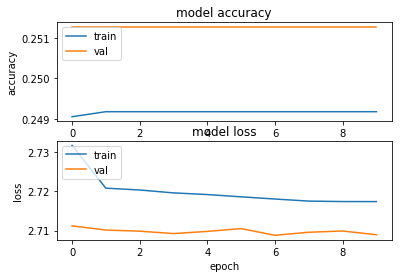

In [238]:
train_top_model(train_dataset_path, val_dataset_path, image_size=150, epochs=10)

In [4]:
# approach 2 - THIS IS THE CORRECT ONE
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers

datagen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 100
NUM_CLASSES = 46
TRAIN_DATA_SIZE = 20000
TEST_DATA_SIZE = 10000
VAL_DATA_SIZE = 10000
# for vgg16
img_h = 150
img_w = 150

dataset_path = "./deepfashion/"
train_dataset_path=os.path.join(dataset_path, "dataset", "train")
test_dataset_path=os.path.join(dataset_path, "dataset", "test")
val_dataset_path=os.path.join(dataset_path, "dataset", "val")

def extract_features(directory, sample_count, n_H=img_h, n_W=img_w, batch_size=BATCH_SIZE, num_category=NUM_CLASSES):
    # since final layer of vgg16 pretrained has 4, 4, 512 dims
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, num_category))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(n_H, n_W),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print("batch=%s, features dim=%s, labels_dim=%s" % (i, features.shape, labels.shape))        
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dataset_path, 20000)
validation_features, validation_labels = extract_features(val_dataset_path, 10000)
test_features, test_labels = extract_features(test_dataset_path, 10000)

Found 209215 images belonging to 46 classes.
batch=1, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=2, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=3, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=4, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=5, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=6, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=7, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=8, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=9, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=10, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=11, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=12, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=13, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=14, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=15, features dim=(20000, 4, 4, 512

batch=125, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=126, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=127, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=128, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=129, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=130, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=131, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=132, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=133, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=134, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=135, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=136, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=137, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=138, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=139, features dim=(20000, 4, 4, 512), labels_dim=(20000,

batch=48, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=49, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=50, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=51, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=52, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=53, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=54, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=55, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=56, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=57, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=58, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=59, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=60, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=61, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=62, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=63, 

batch=72, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=73, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=74, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=75, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=76, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=77, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=78, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=79, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=80, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=81, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=82, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=83, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=84, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=85, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=86, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=87, 

In [5]:
train_features.shape

(20000, 4, 4, 512)

In [6]:
validation_features.shape

(10000, 4, 4, 512)

In [7]:
test_features.shape

(10000, 4, 4, 512)

In [9]:
# The extracted features are currently of shape (samples, 4, 4, 512). 
# We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192)

TRAIN_DATA_SIZE = 20000
TEST_DATA_SIZE = 10000
VAL_DATA_SIZE = 10000


train_features = np.reshape(train_features, (TRAIN_DATA_SIZE, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (VAL_DATA_SIZE, 4 * 4 * 512))
test_features = np.reshape(test_features, (TEST_DATA_SIZE, 4 * 4 * 512))

In [13]:
# save resized features for quick future runs
np.save('vgg16_bottleneck_deepfashion_train_20k_100.npy', train_features)
np.save('vgg16_bottleneck_deepfashion_val_20k_100.npy', validation_features)
np.save('vgg16_bottleneck_deepfashion_test_20k_100.npy', test_features)
np.save('vgg16_deepfashion_train_20k_100_labels.npy', train_labels)
np.save('vgg16_deepfashion_val_20k_100_labels.npy', validation_labels)
np.save('vgg16_deepfashion_test_20k_100_labels.npy', test_labels)

In [34]:
from time import time
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import TensorBoard

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

# add tensorboard callback
# tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
#                           histogram_freq=1, 
#                           write_graph=True, 
#                           write_images=True)

tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
                          write_graph=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 46)                11822     
Total params: 2,109,230
Trainable params: 2,109,230
Non-trainable params: 0
_________________________________________________________________


In [35]:
# set epochs + batch size
NUM_EPOCHS = 100
history = model.fit(train_features, train_labels,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels),
                    verbose=1, callbacks=[tensorboard])

Train on 20000 samples, validate on 10000 samples
Epoch 1/100
20000/20000 [==============================] - 11s 543us/step - loss: 2.9731 - acc: 0.2522 - val_loss: 2.5668 - val_acc: 0.3270
Epoch 2/100
20000/20000 [==============================] - 10s 486us/step - loss: 2.6359 - acc: 0.3193 - val_loss: 2.3946 - val_acc: 0.3561
Epoch 3/100
20000/20000 [==============================] - 10s 486us/step - loss: 2.4819 - acc: 0.3440 - val_loss: 2.2844 - val_acc: 0.3763
Epoch 4/100
20000/20000 [==============================] - 8s 407us/step - loss: 2.3654 - acc: 0.3698 - val_loss: 2.2068 - val_acc: 0.3946
Epoch 5/100
20000/20000 [==============================] - 7s 340us/step - loss: 2.2740 - acc: 0.3843 - val_loss: 2.1457 - val_acc: 0.4060
Epoch 6/100
20000/20000 [==============================] - 8s 380us/step - loss: 2.2038 - acc: 0.3988 - val_loss: 2.1026 - val_acc: 0.4176
Epoch 7/100
20000/20000 [==============================] - 7s 360us/step - loss: 2.1490 - acc: 0.4111 - val_loss:

20000/20000 [==============================] - 8s 376us/step - loss: 1.3109 - acc: 0.6230 - val_loss: 1.7883 - val_acc: 0.4959
Epoch 60/100
20000/20000 [==============================] - 8s 382us/step - loss: 1.2983 - acc: 0.6280 - val_loss: 1.7895 - val_acc: 0.4945
Epoch 61/100
20000/20000 [==============================] - 7s 362us/step - loss: 1.2946 - acc: 0.6304 - val_loss: 1.7880 - val_acc: 0.4951
Epoch 62/100
20000/20000 [==============================] - 7s 366us/step - loss: 1.2826 - acc: 0.6339 - val_loss: 1.7901 - val_acc: 0.4962
Epoch 63/100
20000/20000 [==============================] - 7s 371us/step - loss: 1.2771 - acc: 0.6373 - val_loss: 1.7843 - val_acc: 0.4983
Epoch 64/100
20000/20000 [==============================] - 7s 366us/step - loss: 1.2681 - acc: 0.6376 - val_loss: 1.7858 - val_acc: 0.4985
Epoch 65/100
20000/20000 [==============================] - 7s 357us/step - loss: 1.2579 - acc: 0.6397 - val_loss: 1.7829 - val_acc: 0.4995
Epoch 66/100
20000/20000 [=======

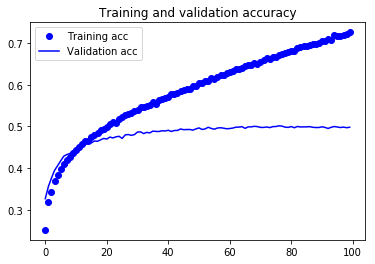

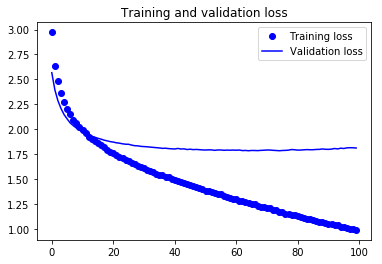

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc (RMSProp=> lr=2e-5)')
plt.plot(epochs, val_acc, 'b', label='Validation acc (RMSProp=> lr=2e-5)')
plt.title('Training and validation accuracy (RMSProp=> lr=2e-5)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss (RMSProp=> lr=2e-5)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (RMSProp=> lr=2e-5)')
plt.title('Training and validation loss (RMSProp=> lr=2e-5)')
plt.legend()

plt.show()

#### Using Adam optimizer with default learning rate

In [48]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# add tensorboard callback
# tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
#                           histogram_freq=1, 
#                           write_graph=True, 
#                           write_images=True)

tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
                          write_graph=True)

In [49]:
# set epochs + batch size
NUM_EPOCHS = 100
adam_history = model.fit(train_features, train_labels,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels),
                    verbose=1, callbacks=[tensorboard])

Train on 20000 samples, validate on 10000 samples
Epoch 1/100
20000/20000 [==============================] - 11s 535us/step - loss: 3.3377 - acc: 0.3330 - val_loss: 2.3669 - val_acc: 0.4009
Epoch 2/100
20000/20000 [==============================] - 9s 474us/step - loss: 2.4559 - acc: 0.3689 - val_loss: 2.2839 - val_acc: 0.3998
Epoch 3/100
20000/20000 [==============================] - 9s 461us/step - loss: 2.3637 - acc: 0.3808 - val_loss: 2.2160 - val_acc: 0.4097
Epoch 4/100
20000/20000 [==============================] - 10s 492us/step - loss: 2.3579 - acc: 0.3787 - val_loss: 2.2394 - val_acc: 0.4126
Epoch 5/100
20000/20000 [==============================] - 10s 498us/step - loss: 2.3324 - acc: 0.3827 - val_loss: 2.1873 - val_acc: 0.4199
Epoch 6/100
20000/20000 [==============================] - 10s 513us/step - loss: 2.3337 - acc: 0.3818 - val_loss: 2.1772 - val_acc: 0.4172
Epoch 7/100
20000/20000 [==============================] - 10s 487us/step - loss: 2.3149 - acc: 0.3854 - val_los

Epoch 59/100
20000/20000 [==============================] - 10s 501us/step - loss: 2.3295 - acc: 0.3595 - val_loss: 2.1646 - val_acc: 0.3909
Epoch 60/100
20000/20000 [==============================] - 9s 471us/step - loss: 2.3339 - acc: 0.3567 - val_loss: 2.1554 - val_acc: 0.3994
Epoch 61/100
 5100/20000 [======>.......................] - ETA: 6s - loss: 2.2791 - acc: 0.3694

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

acc = adam_history.history['acc']
val_acc = adam_history.history['val_acc']
loss = adam_history.history['loss']
val_loss = adam_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc (Adam=> lr=0.001)')
plt.plot(epochs, val_acc, 'b', label='Validation acc (Adam=> lr=0.001)')
plt.title('Training and validation accuracy (Adam=> lr=0.001)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss (Adam=> lr=0.001)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (Adam=> lr=0.001)')
plt.title('Training and validation loss (Adam=> lr=0.001)')
plt.legend()

plt.show()